# Chest X-Ray Diagonosis with Deep Learning

In [ ]:
# importing the libraries - numpy and pandas to manipulate our data, numpy and pandas to manipulate our data, util will provide the locally defined utility functions

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model
import util
import utils
from sklearn import metrics

# Loading the Datasets -

## We are using the ChestX-ray8 dataset which contains 108,948 frontal-view X-ray images of 32,717 unique patients.

In [40]:
train_df = pd.read_csv("data/train-small.csv")
valid_df = pd.read_csv("data/valid-small.csv")

test_df = pd.read_csv("data/test.csv")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [4]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

# Preventing Data Leakage - 

## Our dataset might contain multiple images of a single patient. This could be a case when a patient has taken multiple X-Rays at different times during hospital visits. So before spliting into train, validation & test dataset we have to make sure that there is no data leakage.

In [24]:
def check_for_leakage(df1, df2, patient_col):
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)

    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)
    
    leakage = len(patients_in_both_groups) > 0
    
    return leakage       

In [6]:
print("test case 1")
df1 = pd.DataFrame({'patient_id': [0, 1, 2]})
df2 = pd.DataFrame({'patient_id': [2, 3, 4]})
print("df1")
print(df1)
print("df2")
print(df2)
print(f"leakage output: {check_for_leakage(df1, df2, 'patient_id')}")
print("-------------------------------------")
print("test case 2")
df1 = pd.DataFrame({'patient_id': [0, 1, 2]})
df2 = pd.DataFrame({'patient_id': [3, 4, 5]})
print("df1:")
print(df1)
print("df2:")
print(df2)

print(f"leakage output: {check_for_leakage(df1, df2, 'patient_id')}")

test case 1
df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           2
1           3
2           4
leakage output: None
-------------------------------------
test case 2
df1:
   patient_id
0           0
1           1
2           2
df2:
   patient_id
0           3
1           4
2           5
leakage output: False


## If we get False for both, then we're ready to start preparing the datasets for training.

In [25]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: False
leakage between valid and test: False


## Here are the functions for the data generator for reading the pictures and converting them to float32 tensors and feed them to the network

## We will be building separate generator for valid and test sets

In [8]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    print("getting train generator...") 
    # normalizing the images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [9]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator
    
    

In [10]:
IMAGE_DIR = "data/images/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...


D:\Anaconda\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 927 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 73 validated image filenames.
getting train and valid generators...
Found 73 validated image filenames.
Found 13 validated image filenames.
Found 32 validated image filenames.


D:\Anaconda\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 96 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)
D:\Anaconda\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 388 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


## Let's see what the generator gives our model during training and validation. We can do this by calling the __get_item__(index) function

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


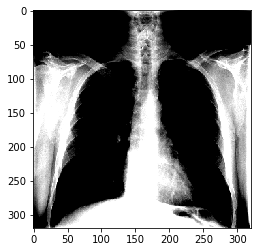

In [37]:

x, y = train_generator.__getitem__(1)
plt.imshow(x[1]);

## One of the major challenge with working with medical diagnostic datasets is the large class imbalance present in such datasets. Let's plot the frequency of each of the labels in our dataset:

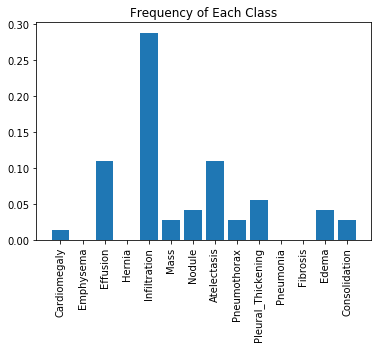

In [12]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [13]:
def compute_class_freqs(labels):
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies


    return positive_frequencies, negative_frequencies
    

In [14]:
labels_matrix = np.array(
    [[1, 0, 0],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
     [1, 0, 1]]
)
print("labels:")
print(labels_matrix)

test_pos_freqs, test_neg_freqs = compute_class_freqs(labels_matrix)

print(f"pos freqs: {test_pos_freqs}")

print(f"neg freqs: {test_neg_freqs}")

labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
pos freqs: [0.8 0.4 0.8]
neg freqs: [0.2 0.6 0.2]


In [15]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.01369863, 0.        , 0.10958904, 0.        , 0.28767123,
       0.02739726, 0.04109589, 0.10958904, 0.02739726, 0.05479452,
       0.        , 0.        , 0.04109589, 0.02739726])

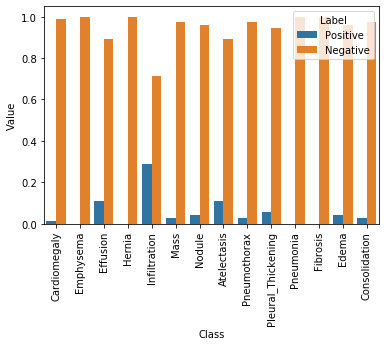

In [16]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [17]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

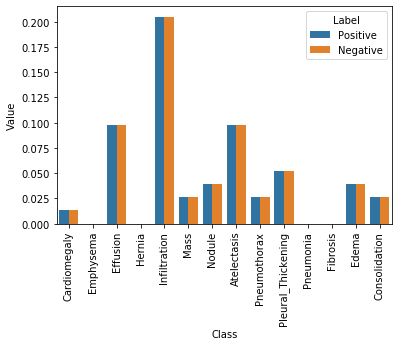

In [18]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [19]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos_weights)):
            
            loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon) 
                             + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon)))
        return loss  
    
    return weighted_loss       

In [20]:
base_model = DenseNet121(weights='./data/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

Epoch 1/2
100/100 [==============================] - 2119s 21s/step - loss: 0.5825 - val_loss: 3.9382
Epoch 2/2
100/100 [==============================] - 1936s 19s/step - loss: 0.2369 - val_loss: 4.8714


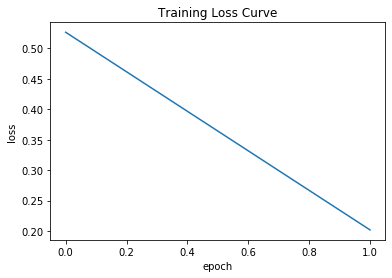

In [21]:
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 2)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [26]:
model.load_weights("./data/pretrained_model.h5")

In [27]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

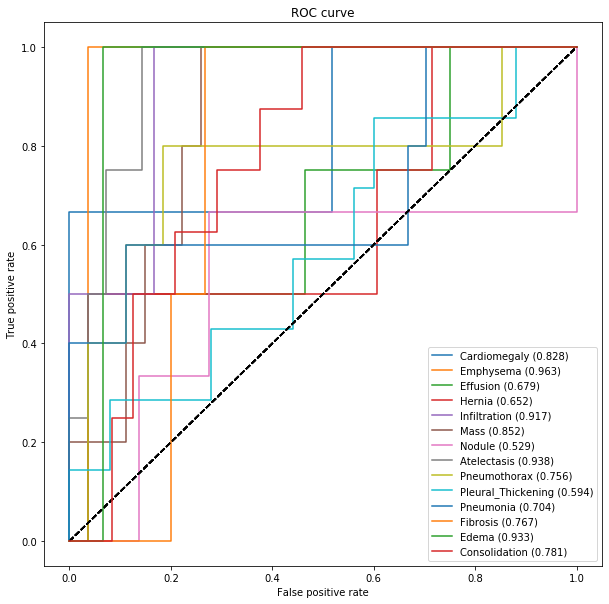

In [28]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

In [29]:
df = pd.read_csv("data/train-small.csv")
IMAGE_DIR = "data/images/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

Loading original image
Generating gradcam for class Emphysema
Generating gradcam for class Infiltration
Generating gradcam for class Atelectasis
Generating gradcam for class Edema


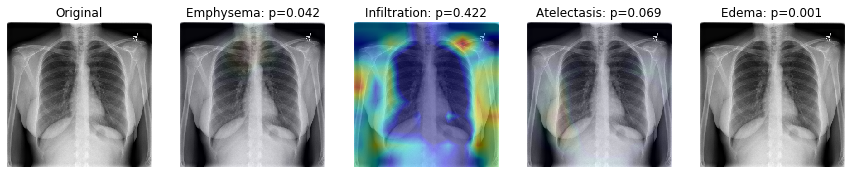

In [30]:
util.compute_gradcam(model, '00020950_000.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Emphysema
Generating gradcam for class Infiltration
Generating gradcam for class Atelectasis
Generating gradcam for class Edema


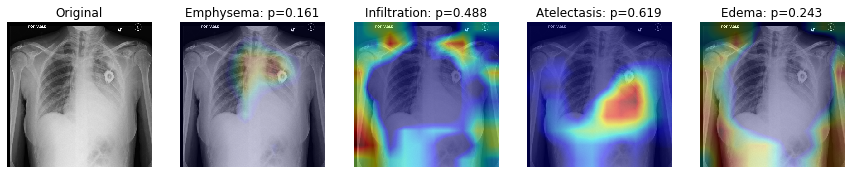

In [31]:
util.compute_gradcam(model, '00020956_000.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Emphysema
Generating gradcam for class Infiltration
Generating gradcam for class Atelectasis
Generating gradcam for class Edema


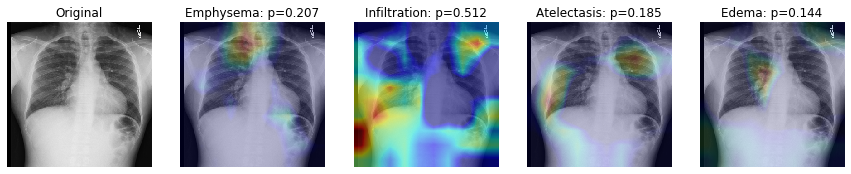

In [34]:
util.compute_gradcam(model, '00020986_000.png', IMAGE_DIR, df, labels, labels_to_show)